In [275]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [276]:
start = "2000"
end = "2023"
test_size = 0.3

In [277]:
SPY = yf.download("SPY", f"{start}-01-01", f"{end}-06-30", interval='1d')["Close"].to_frame()
SPY.rename(columns={"Close":"SPY"}, inplace=True)

[*********************100%***********************]  1 of 1 completed


In [278]:
lags = 5
cols = []
instrument = pd.DataFrame()
instrument["Returns"] = np.log(SPY/SPY.shift())
instrument["Direction"] = np.sign(instrument["Returns"])
instrument["Std"] = instrument["Returns"].std()
for lag in range (1, lags+1):
    col = f"ret_lag_{lag}"
    instrument[col] = instrument.Returns.shift(lag)
    cols.append(col)
for lag in range (1, lags+1):
    col = f"std_lag_{lag}"
    instrument[col] = instrument.Std.shift(lag)
    cols.append(col)
instrument.dropna(inplace = True)

In [279]:
X = instrument[cols]
y = instrument.Direction
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
instrumentModel = LogisticRegression(C = 1e6, max_iter = 100000, multi_class = "ovr")
instrumentModel.fit(X_train, y_train)
instrument["Pred"] = instrumentModel.predict(instrument[cols])
instrument.Pred.value_counts()

 1.0    5501
-1.0     403
Name: Pred, dtype: int64

In [280]:
FFR = pd.read_csv("FederalFundsRate.csv", index_col="Date", parse_dates=["Date"]).loc[start:end]
Core_CPI = pd.read_csv("CoreCPI.csv", index_col="Date", parse_dates=["Date"]).loc[start:end]
PPI = pd.read_csv("PPI.csv", index_col="Date", parse_dates=["Date"]).loc[start:end]
Unemployment = pd.read_csv("UnemploymentRate.csv", index_col="Date", parse_dates=["Date"]).loc[start:end]
GDP = pd.read_csv("GDP.csv", index_col="Date", parse_dates=["Date"]).loc[start:end]

In [281]:
df = pd.concat([FFR, Core_CPI, PPI, Unemployment, GDP], axis=1, join="outer").dropna(how="all").ffill()
df.bfill(inplace=True)
df.index = pd.to_datetime(df.index)
df = pd.concat([SPY, df], axis=1, join="inner")

In [282]:
macro = pd.DataFrame()
# bar movement when there is a change in features
macro["Direction2"] = np.sign(np.log(df.SPY/df.SPY.shift())).shift(-1)   
macro["delFFR"] = df.FFR - df.FFR.shift()
macro["delCPI"] = df.FFR - df.FFR.shift()
macro["delPPI"] = df.FFR - df.FFR.shift()
macro["delUnemployment"] = df.Unemployment - df.Unemployment.shift()
macro["delGDP"] = np.log(df.GDP/df.GDP.shift())
macro.dropna(inplace=True)

In [283]:
lags = 5
features = ["delFFR", "delCPI", "delPPI", "delUnemployment", "delGDP"]
macroCols = []
for feat in features:
    for lag in range (1, 1+lags):
        col = f"{feat}_{lag}"
        macro[col] = macro[feat].shift(lag)
        macroCols.append(col)
macro.dropna(inplace=True)

In [284]:
# X = macro[["delFFR", "delCPI", "delPPI", "delUnemployment", "delGDP"]]
X = macro[macroCols]
y = macro.Direction2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
macroModel = LogisticRegression(C = 1e6, max_iter = 100000, multi_class = "ovr")
macroModel.fit(X_train, y_train)
macro["Pred2"] = macroModel.predict(X)
macro.Pred2.value_counts()

 1.0    205
-1.0     28
Name: Pred2, dtype: int64

In [285]:
data = pd.concat([instrument, macro], axis=1, join="outer").ffill().dropna()
data["Position"] = np.where((data["Pred"] * data["Pred2"] > 0), 1, 0)
# data["Position"] = np.where((data["Pred"] > 0), 1, 0)
data["Strategy"] = data["Position"] * data["Returns"]
data["creturns"] = data["Returns"].cumsum().apply(np.exp)
data["cstrategy"] = data["Strategy"].cumsum().apply(np.exp)
data.Pred2.value_counts()
# data

 1.0    5084
-1.0     722
Name: Pred2, dtype: int64

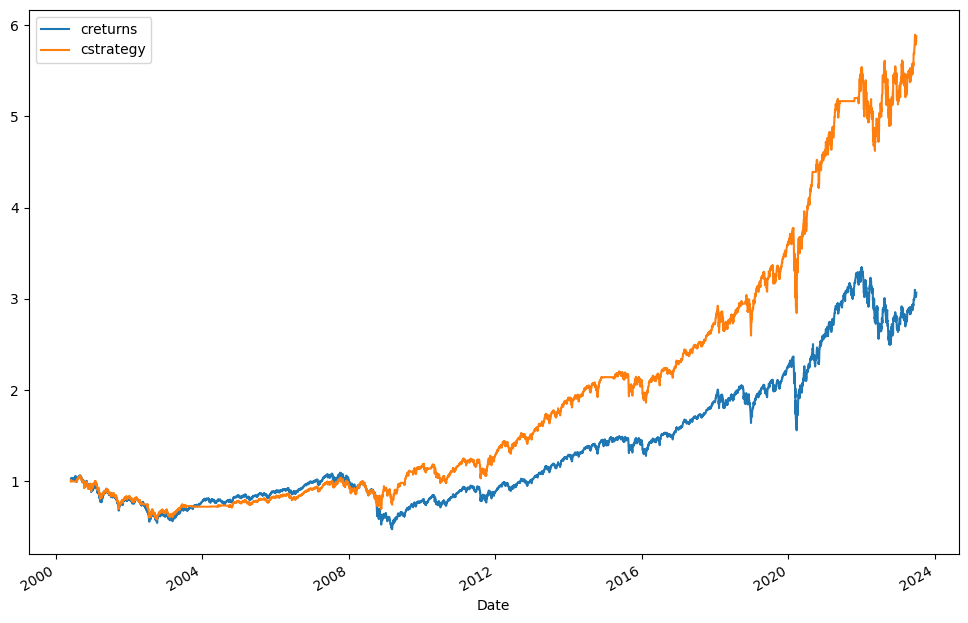

In [286]:
data[["creturns", "cstrategy"]].plot(figsize = (12 , 8))
plt.show()

In [287]:
data["trades"] = data.Pred.diff().fillna(0).abs()
data.trades.value_counts()

0.0    5226
2.0     580
Name: trades, dtype: int64

In [288]:
hits = np.sign(data.Returns*data.Position).value_counts()
hit_ratio = hits[1.0]/sum(hits)
hit_ratio

0.4441956596624182

In [289]:
data.tail()

,Returns,Direction,Std,ret_lag_1,ret_lag_2,ret_lag_3,ret_lag_4,ret_lag_5,std_lag_1,std_lag_2,...,delGDP_2,delGDP_3,delGDP_4,delGDP_5,Pred2,Position,Strategy,creturns,cstrategy,trades
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-23,-0.007589,-1.0,0.012481,0.003603,-0.005137,-0.005202,-0.007120,0.012321,0.012481,0.012481,...,0.0,0.0,0.014878,0.0,1.0,1,-0.007589,3.033418,5.810003,0.0
2023-06-26,-0.004094,-1.0,0.012481,-0.007589,0.003603,-0.005137,-0.005202,-0.007120,0.012481,0.012481,...,0.0,0.0,0.014878,0.0,1.0,1,-0.004094,3.021024,5.786265,0.0
2023-06-27,0.010904,1.0,0.012481,-0.004094,-0.007589,0.003603,-0.005137,-0.005202,0.012481,0.012481,...,0.0,0.0,0.014878,0.0,1.0,1,0.010904,3.054145,5.849701,0.0
2023-06-28,0.000504,1.0,0.012481,0.010904,-0.004094,-0.007589,0.003603,-0.005137,0.012481,0.012481,...,0.0,0.0,0.014878,0.0,1.0,1,0.000504,3.055685,5.852652,0.0
2023-06-29,0.003934,1.0,0.012481,0.000504,0.010904,-0.004094,-0.007589,0.003603,0.012481,0.012481,...,0.0,0.0,0.014878,0.0,1.0,1,0.003934,3.067729,5.875719,0.0
